# World Heritage Outlook analysis 2 - 2017

## Update runs
- 170724 Run
- 170817 Run 
- 170913 Run
- 170929 Run
- 171011 Run

## About

The 2017 cycle of assessments will not be ready until later September/October. This notebook is an attempt to:

1. Experiment the methodology that allows rapid analysis to be repeated with little efforts. The goal is to complete the analysis within short time, when the final data have become available
2. Experiment open and reproducible analysis that anyone interested could critique, repeat or improve the methodolgy if they so wish
3. Test ideas and scrutise the result, to uncover inconsistency and enable future iterations of outlook assessment to be more systematic and consistent

### The analysis so far
- load CSV data (pre-processed data dumps from PostgreSQL/MS Access) into the notebook
- utility functions to find relevant rows in the data, based on `wdpaid` and `assessment_cycle`
- generic summary statistics (using `pandas.DataFrame.pivot_table`), for the `overall` table, notably including the `outlook` ratings. This is implemented so that any dataframe with filtered rows could be done easily, i.e., allowing subsetting by regions, countries, any attribute criteria
- generic field-by-field change detction for the `overall` table. This is useful to identify the lowest level change (i.e. field level change for each site) but also provides a mechanism for quality control as odd changes that should not happen could be easily identified
- generic pivot table counting for any data. I tested the functionality using `potential_threat`, in which different groups of threat categories are needed
- viz: outlook, and its comparison
- viz: heatmap for threats, the charts are interactive, allowing users to interrogate each cell (powered by Plot.ly)
- finding associations between values, pm and threats to the final outlook rating
- finding inconsistencies between individual threat listing and severity to the final threat rating 
- find sites and analyse based on internal filters, such as specific threats or management
- regional filters are now in place for the overall table
    
### Ideas
- attribute filters: regions, marine, country, WH criteria, danger status. This could be easily implemented as the only change would be the input. As long as the analysis is designed in such a way that allow such input to be changed at a later stage.

## Data preparation and exploration

Load relevant analytical and graphing libraries

In [186]:
import os, sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [187]:
# %matplotlib inline

import plotly library for plotting

In [188]:
#install openpyxl, if needed
!pip install openpyxl

In [189]:
import plotly
plotly.tools.set_credentials_file(username='yichuans', api_key='DjWuYpvtG8nFh8A9U8Jb')

# ensure offline viewing of plotly graphs
# plotly.offline.init_notebook_mode(connected=True)

import plotly.plotly as py
import plotly.figure_factory as ff

from plotly.graph_objs import Bar

Checking folder structure - for the analysis to correctly continue, you must have `WH_attributes_2017.csv`, `overall.csv`, `potential_threat.csv`, `current_threat.csv`, `protection_manament_threat.csv`, `who_value_current_threat.csv` and `who_value_potential_threat.csv`. These tables are obtained using the methodology previoulsy employed during the 2014 assessment. For detailed steps please consult Yichuan or Matea. 

In [190]:
!ls

WH_attributes_2017.csv         old171011
WH_region.csv                  overall.csv
analysis.ipynb                 potential_threat.csv
current_threat.csv             protection_management.csv
old                            who_value.csv
old170817                      who_value_current_threat.csv
old170929                      who_value_potential_threat.csv


Loading data into dataframes

In [191]:
overall = pd.read_csv('overall.csv', encoding='latin1')
current_threat = pd.read_csv('current_threat.csv', encoding='latin1')
potential_threat = pd.read_csv('potential_threat.csv', encoding='latin1')
protection_management = pd.read_csv('protection_management.csv', encoding='latin1')
value_current_threat = pd.read_csv('who_value_current_threat.csv', encoding='latin1')
value_potential_threat = pd.read_csv('who_value_potential_threat.csv', encoding='latin1')
wh_attr = pd.read_csv('WH_attributes_2017.csv')
wh_region = pd.read_csv('WH_region.csv')

For consistency checks, we need to ensure the number of records are consistent with our knowledge of the assessments. The `overall.index.size` indicates the number of rows (2014 + 2017) and `overall.wdpa_id.unique()` the unique number of sites for 2014 and 2017. When the 2017 assessments are uploaded to the database in full, we expect it to be **241**

In [192]:
overall.index.size, overall.wdpa_id.nunique()

(467, 239)

The below checks on whether `pm_rating` has been filled for all assessments, if any values are labelled `NaN`, we need to validate if assessment for each topic is complete as it should.

In [193]:
protection_management[pd.isnull(protection_management.pm_rating)]

wdpa_id       screenname       status       stage  \
932      903062           mizuki    Completed      Review   
2142       2012           mizuki    Completed      Review   
2172  555547988            remco    Completed      Review   
2187       2017            remco    Completed      Review   
2206      26689           mizuki    Completed      Review   
2222      67730            elena    Completed      Review   
2226       5001            elena    Completed      Review   
3340      61609            elena    Completed  Assessment   
3354  555556048            elena    Completed  Assessment   
3372  555577555             alan    Completed  Assessment   
3381     903138            tarek    Completed  Assessment   
3403      93767         alexbond    Completed  Assessment   
3415     902479            wendy    Completed  Assessment   
3435     903132           mizuki    Completed  Assessment   
3456     903135       elenaperez    Completed  Assessment   
3471      18862            elena    Completed  Assessment   
3485       9613       elenaperez    Completed  Assessment   
3499      12206       elenaperez    Completed  Assessment   
3509  555512006            elena  In Progress  Assessment   
3510     145580            naomi    Completed  Assessment   
3527     903134  catherinegabrie    Completed  Assessment   
3556      10907      vernonbooth    Completed  Assessment   
3557      10907      vernonbooth    Completed  Assessment   
3572      20399      vernonbooth    Completed  Assessment   
3573      20399      vernonbooth    Completed  Assessment   
3579      20062          thierry    Completed  Assessment   
3590       4326       elenaperez    Completed  Assessment   
3613     900880            elena    Completed  Assessment   
3624     900633            wendy    Completed  Assessment   
3646      14177            naomi    Completed  Assessment   
...         ...              ...          ...         ...   
6463       2573            elena  In Progress  Assessment   
6475  555512003            elena    Completed  Assessment   
6492  555622045            remco    Completed      Review   
6498       4999            remco    Completed      Review   
6520  555547992            elena  In Progress  Assessment   
6521  555547992            elena  In Progress  Assessment   
6556     902487            remco    Completed      Review   
6568       2580            remco    Completed  Assessment   
6585  555622043            remco    Completed      Review   
6601      17759           mizuki    Completed      Review   
6619     124383            elena  In Progress  Assessment   
6628      16792            elena    Completed  Assessment   
6646      10904           mizuki    Completed      Review   
6663  555547989            elena    Completed  Assessment   
6685       2578            elena    Completed      Review   
6708     220295       elenaperez    Completed  Assessment   
6731     900632           mizuki    Completed      Review   
6737     902335            remco    Completed  Assessment   
6760      12202            elena    Completed  Assessment   
6799      20171            elena    Completed  Assessment   
6831     478641       elenaperez    Completed  Assessment   
6855      10902           mizuki    Completed      Review   
6860       2572            elena    Completed      Review   
6884      61604            elena    Completed      Review   
6905     900010            elena  In Progress  Assessment   
6906     900010            elena  In Progress  Assessment   
6922     903133            elena    Completed  Assessment   
6950     902368            elena    Completed  Assessment   
6955     900878            elena    Completed  Assessment   
6978      12207           mizuki    Completed      Review   

                                                name_en  \
932                       Rainforests of the Atsinanana   
2142                           Everglades National Park   
2172                                 Sangha Trin

## Overall conservation outlook

Filters for 2014 and 2017 cycles of assessment so that different versions can be specified easily. Note this is only a *convenient* method for the overall table alone.

In [194]:
CYCLE_2017_OVERALL = overall.assessment_cycle == 2017
CYCLE_2014_OVERALL = overall.assessment_cycle == 2014

The number of unique records for 2014 and 2017 cycles

In [195]:
overall[CYCLE_2014_OVERALL].wdpa_id.nunique(), overall[CYCLE_2017_OVERALL].wdpa_id.nunique()

(229, 238)

Quality checks on the data: what are the sites that are in 2014 but not in 2017 and vice versa? Or what is the number of sites that have two assessments?

In [196]:
wdpaid_shared_between_cycles = overall[CYCLE_2014_OVERALL].wdpa_id.isin(overall[CYCLE_2017_OVERALL].wdpa_id.values)
print('Total number of shared sites between two cycles: {}'.format(wdpaid_shared_between_cycles.sum()))

Total number of shared sites between two cycles: 228


#### Regions
Regional filters

In [197]:
wh_region.unesco_region.unique()

array(['Africa', 'Arab States', 'Asia and the Pacific',
       'Europe and North America', 'Latin America and the Caribbean'], dtype=object)

`region_dict` is a dictionary of region_name: list of wdpaid in that region

In [198]:
region_dict = {region_name: wh_region[wh_region.unesco_region==region_name].wdpaid \
              for region_name in wh_region.unesco_region.unique()}

### Overall outlook statistics

Overall outlook for 2014

In [199]:
overall[CYCLE_2014_OVERALL].pivot_table(values='wdpa_id', columns='outlook', aggfunc=np.count_nonzero)

outlook  Critical  Good  Good with some concerns  Significant Concern
wdpa_id        19    47                       96                   67

A more generic version of number statistics are needed to facilitate pivot tables

In [200]:
## create a more generic version of get number statistics
def summary_statistics(df, columns, aggfunc=np.count_nonzero):
    result = df.pivot_table(values='wdpa_id', columns=columns, aggfunc=aggfunc)
    result.index = [' '] # remove wdpa_id as index value
    return result

For example, the previous pivot table analysis could be re-calculated as the following, i.e. overall outlook for 2014

In [201]:
summary_statistics(overall[CYCLE_2014_OVERALL], 'outlook')

outlook  Critical  Good  Good with some concerns  Significant Concern
               19    47                       96                   67

With the `summary_statistics` function, one further automation could be achieved by looping with the different column names.

The below loops through all columns name and count the number of sites by rating, iteratively, for 2014 assessment. I also made a copy of Excel table to facilitate intepretation for those prefer Excel tables. This allows also other visualisations to be created outside the notebook environment

#### Overall result for 2014

The below shows the count by category for outlook, threat, protection and management, and value 

In [202]:
# write to excel
writer = pd.ExcelWriter('output_cycle2014_summary.xlsx')

cols = [u'status', u'stage', u'outlook', u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt', u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language']
for col in cols:
    col_result = summary_statistics(overall[CYCLE_2014_OVERALL], col)
    col_result.to_excel(writer, col)
    print col_result
    
writer.save()

status  Completed  In Progress
              228            1
stage  Approved  Assessment  Published  Translated
              1           1        224           3
outlook  Critical  Good  Good with some concerns  Significant Concern
               19    47                       96                   67
overall_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         90          88                33               18
current_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         89          91                30               19
potential_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                              26           84          71                24   

potential_threat  Very Low Threat  
                               15  
prot_mgmt  Effective  Highly Effective  Serious Concern  Some Concern
                 103                23               29            74
wh_value  Critical  Good 

#### Overall result for 2014 by region
Similar to the above but by region

In [203]:
for region in region_dict:
    print '\n----' + '-'*len(region) + '----'
    print '    ' + region + '    '
    print '----' + '-'*len(region) + '----\n'
    writer = pd.ExcelWriter('output_region_cycle2014_summary_{}.xlsx'.format(region.replace(' ', '_')))

    cols = [u'status', u'stage', u'outlook', u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt', u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language']
    for col in cols:
        df = overall[CYCLE_2014_OVERALL & overall.wdpa_id.isin(region_dict[region])]
        col_result = summary_statistics(df, col)
        col_result.to_excel(writer, col)
        print col_result
    writer.save()


--------------------------------
    Europe and North America    
--------------------------------

status  Completed
               71
stage  Published
              71
outlook  Critical  Good  Good with some concerns  Significant Concern
                1    23                       32                   15
overall_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         22          31                 5               13
current_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         25          27                 4               15
potential_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                               8           23          23                 5   

potential_threat  Very Low Threat  
                               11  
prot_mgmt  Effective  Highly Effective  Serious Concern  Some Concern
                  36                12                5            18
wh_value  Critical

#### Overall result for 2017

In [204]:
# also write to excel
writer = pd.ExcelWriter('output_cycle2017_summary.xlsx')

cols = [u'status', u'stage', u'outlook', u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt', u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language']
for col in cols:
    col_result = summary_statistics(overall[CYCLE_2017_OVERALL], col)
    col_result.to_excel(writer, col)
    print col_result
    
writer.save()

status  Completed  In Progress
              217           21
stage  Assessment  Review
              207      31
outlook  Critical  Good  Good with some concerns  Significant Concern
               16    46                      100                   75
overall_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                             1           98          90                34   

overall_threat  Very Low Threat  
                             14  
current_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                             2          104          82                31   

current_threat  Very Low Threat  
                             18  
potential_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                              26           90          79                22   

potential_threat  Very Low Threat  
                               14  
prot_mgmt  Effective  Highly Effective  Serious Concern  Some Concern

By adding further filters, such as regions/countries/(other attributes), in the form of list of wdpaids, it can calculate statistics reusing the `summary_statistics` function. TBD: apply wdpaid filter, perhaps `isin`

#### Overall result for 2017 by region
Similar to the above but by region

In [205]:
for region in region_dict:
    print '\n----' + '-'*len(region) + '----'
    print '    ' + region + '    '
    print '----' + '-'*len(region) + '----\n'
    writer = pd.ExcelWriter('output_region_cycle2017_summary_{}.xlsx'.format(region.replace(' ', '_')))

    cols = [u'status', u'stage', u'outlook', u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt', u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language']
    for col in cols:
        df = overall[CYCLE_2017_OVERALL & overall.wdpa_id.isin(region_dict[region])]
        col_result = summary_statistics(df, col)
        col_result.to_excel(writer, col)
        print col_result
    writer.save()


--------------------------------
    Europe and North America    
--------------------------------

status  Completed  In Progress
               67            5
stage  Assessment  Review
               64       8
outlook  Critical  Good  Good with some concerns  Significant Concern
                1    22                       28                   20
overall_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         26          29                 6               10
current_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         32          24                 3               12
potential_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                               9           20          26                 5   

potential_threat  Very Low Threat  
                               11  
prot_mgmt  Effective  Highly Effective  Serious Concern  Some Concern
                  29                11      

### Overall outlook visualisation
Investigate visualisation options, for overall outlook. 

In [206]:
print(plt.style.available)

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [207]:
plt.style.use('ggplot')

The default style with `ggplot`

In [208]:
def plot_outlook(df):
    # use WHO colour scheme
    red, orange, green, deep_green, grey =('#E22626','#F69220', '#ACCD73', '#49AA4A', '#A0A0A0')
    fig, axes = plt.subplots(1, figsize=(20, 2))
    
    my_colors = [deep_green, green, orange, red]
    my_labels = ['Good', 'Good with some concerns', 'Significant Concern', 'Critical']
    data = df[my_labels]

    c = data.plot.barh(ax=axes, stacked=True, color=my_colors)
    axes.set_xlim([0, data.values.sum()])
    axes.legend_.remove()
    
    # ensure all 1-d array to zip, thus flatten
    for value, value_cum, label in zip(data.values.flatten(), data.values.cumsum(), my_labels):
        axes.annotate(label + ' ({})'.format(value), (value_cum - value/2.0, 0),
                      horizontalalignment='center', verticalalignment='center')
    
    return fig

In [209]:
## a genric plot function, requiring the scheme to be sorted before hand
def plot_summary_statistics(df):
    # use WHO colour scheme
    red, orange, green, deep_green, grey =('#E22626','#F69220', '#ACCD73', '#49AA4A', '#A0A0A0')
    fig, axes = plt.subplots(1, figsize=(20, 2))
    
    my_colors = [deep_green, green, orange, red, grey]
    my_labels = df.columns
    data = df

    c = data.plot.barh(ax=axes, stacked=True, color=my_colors)
    axes.set_xlim([0, data.values.sum()])
    axes.legend_.remove()
    
    # ensure all 1-d array to zip, thus flatten
    for value, value_cum, label in zip(data.values.flatten(), data.values.cumsum(), my_labels):
        axes.annotate(label + ' ({})'.format(value), (value_cum - value/2.0, 0),
                      horizontalalignment='center', verticalalignment='center')
    
    return fig

**Overall outlook 2014**

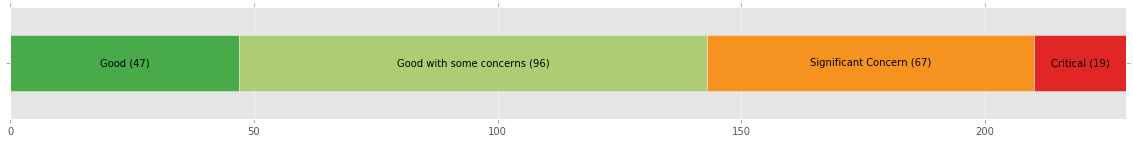

In [210]:
plot_outlook(summary_statistics(overall[CYCLE_2014_OVERALL], 'outlook'))

**Overall outlook 2017**

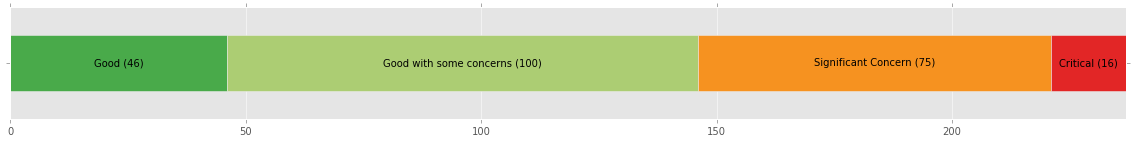

In [211]:
plot_outlook(summary_statistics(overall[CYCLE_2017_OVERALL], 'outlook'))

Testing generic statistics ploting function, noting the need to re-order columns

**Potential threat 2014**

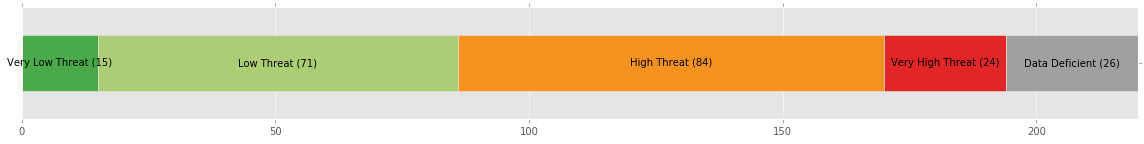

In [212]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2014_OVERALL], 'potential_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat', 'Data Deficient']])

**Potential threat 2017**

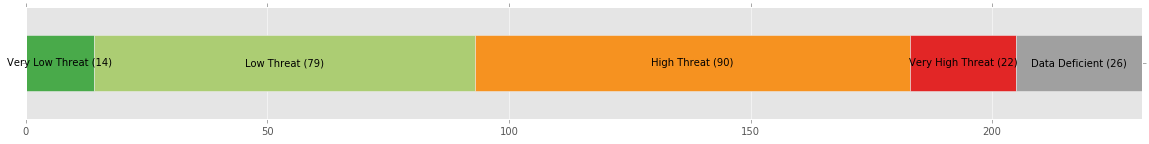

In [213]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2017_OVERALL], 'potential_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat', 'Data Deficient']])

**Current threat 2014**

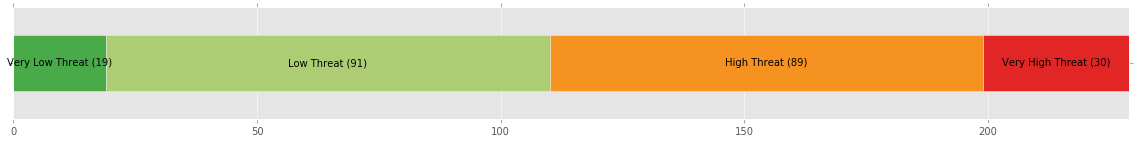

In [214]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2014_OVERALL], 'current_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat']])

**Current threat 2017**

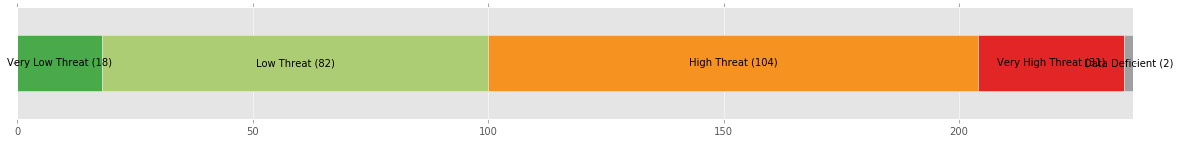

In [215]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2017_OVERALL], 'current_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat', 'Data Deficient']])

**Protection and management 2014**

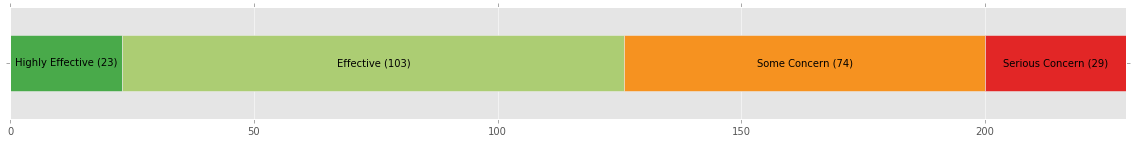

In [216]:
plot_summary_statistics(
    summary_statistics(overall[CYCLE_2014_OVERALL], 'prot_mgmt')[[ 'Highly Effective','Effective', 'Some Concern','Serious Concern']])

**Protection and management 2017**

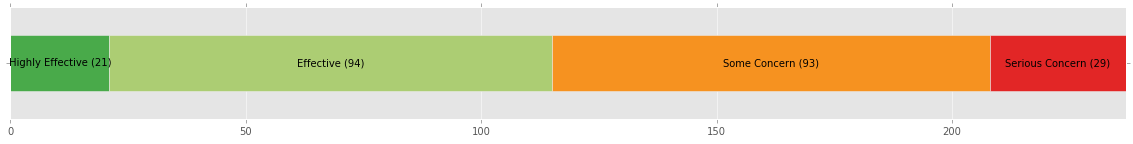

In [217]:
plot_summary_statistics(
    summary_statistics(overall[CYCLE_2017_OVERALL], 'prot_mgmt')[['Highly Effective','Effective', 'Some Concern','Serious Concern']])

### Detect change from 2014 and 2017

It is desirable to know what change may have occurred in each site (if any). The goal is to identify at the lowest level, i.e., for each column, for example, what has 'current threat' changed for Galapogas from 2014 to 2017

In [218]:
common_wdpaids = overall[CYCLE_2014_OVERALL].wdpa_id[overall[CYCLE_2014_OVERALL].wdpa_id.isin(overall[CYCLE_2017_OVERALL].wdpa_id)]

In [219]:
def detect_change_col(wdpaid, df, col):
    """"one row per cycle, i.e. one to one relationship"""
    # brutal force not efficient, first row
    value_2017 = df[(df.assessment_cycle==2017) & (df.wdpa_id==wdpaid)][col].iloc[0]
    value_2014 = df[(df.assessment_cycle==2014) & (df.wdpa_id==wdpaid)][col].iloc[0]
    
    if value_2017 == value_2014:
        return None
    
    # if both variables are of type float and nan, don't do anything
    elif isinstance(value_2017, float) and isinstance(value_2014, float):
        if math.isnan(value_2017) and math.isnan(value_2014):
            return None
        
    # detected change, record
    else:
        return ' -> '.join(map(str, [value_2014, value_2017]))

def detect_change_df(df):
    output = list()
    
    # go through all fields and remove unnecesary fields
    excluded_cols = ['wdpa_id', 'screenname', 'status', 'stage', 'assessment_cycle']
    cols = df.columns.tolist()

    for excluded_col in excluded_cols:
        if excluded_col in cols:
            cols.remove(excluded_col)
    
    # for each site do detection check
    for wdpaid in common_wdpaids:
        for col in cols:
            result = detect_change_col(wdpaid, df, col)
            # if detected
            if result:
                output.append([wdpaid, col, result])
    
    # append en_name 
    output_df = pd.DataFrame(data=output, columns=['wdpaid', 'column', 'value'])
    output_full = pd.merge(output_df, wh_attr, how='inner', on='wdpaid')[['wdpaid', 'en_name', 'column', 'value']]
    
    return output_full

In [220]:
changed_stats = detect_change_df(overall)

Example of the result of change per column

In [221]:
changed_stats.head(20)

wdpaid                                   en_name            column  \
0     2010              Ngorongoro Conservation Area      biodiv_value   
1     2010              Ngorongoro Conservation Area      biodiv_trend   
2    17761                 Kilimanjaro National Park      biodiv_value   
3    17761                 Kilimanjaro National Park      biodiv_trend   
4     2580                Niokolo-Koba National Park  potential_threat   
5     2580                Niokolo-Koba National Park      biodiv_value   
6   902487              Wadi Al-Hitan (Whale Valley)           outlook   
7    67727           Aïr and Ténéré Natural Reserves  potential_threat   
8    67727           Aïr and Ténéré Natural Reserves         prot_mgmt   
9    67727           Aïr and Ténéré Natural Reserves          language   
10   61608          Rwenzori Mountains National Park         prot_mgmt   
11    4322                     Ichkeul National Park           outlook   
12    4322                     Ichkeul National Park          wh_value   
13    4322                     Ichkeul National Park          language   
14   26653  Tsingy de Bemaraha Strict Nature Reserve           outlook   
15   26653  Tsingy de Bemaraha Strict Nature Reserve    overall_threat   
16   26653  Tsingy de Bemaraha Strict Nature Reserve    current_threat   
17    4328                Kahuzi-Biega National Park          wh_trend   
18  478640                      Hierapolis-Pamukkale    overall_threat   
19  478640                      Hierapolis-Pamukkale    current_threat   

                                             value  
0                               nan -> Low Concern  
1                            nan -> Data Deficient  
2                    Data Deficient -> Low Concern  
3                  Data Deficient -> Deteriorating  
4                  High Threat -> Very High Threat  
5                       Critical -> Data Deficient  
6                  Good -> Good with some concerns  
7                    Data Deficient -> High Threat  
8                  Serious Concern -> Some Concern  
9                                           1 -> 2  
10                       Effective -> Some Concern  
11  Significant Concern -> Good with some concerns  
12                     High Concern -> Low Concern  
13                                          2 -> 1  
14                 Good -> Good with some concerns  
15                       Low Threat -> High Threat  
16                       Low Threat -> High Threat  
17                 Data Deficient -> Deteriorating  
18                       High Threat -> Low Threat  
19                       High Threat -> Low Threat

The above table exported to an excel table `output_changed_stats.xlsx`

In [222]:
# export to excel
writer = pd.ExcelWriter('output_changed_stats.xlsx')
changed_stats.to_excel(writer, encoding='utf-8')
writer.save()

`pd.pivot` can be used to identify site specific change for all fields. Note the `columns` argument that for each value in the column would be made a column in the resulting pivot table

In [223]:
changed_stats_by_site = changed_stats.pivot( 'en_name', columns='column', values='value')

#### Site level change in overall from 2014 - 2017

In [224]:
changed_stats_by_site

column                                                                 biodiv_trend  \
en_name                                                                               
Alejandro de Humboldt National Park                           Data Deficient -> nan   
Area de Conservación Guanacaste                                                None   
Atlantic Forest Southeast Reserves                                             None   
Aïr and Ténéré Natural Reserves                                                None   
Belize Barrier Reef Reserve System                                             None   
Białowieża Forest                                                              None   
Brazilian Atlantic Islands: Fernando de Noronha...                             None   
Bwindi Impenetrable National Park                                     nan -> Stable   
Canadian Rocky Mountain Parks                               Stable -> Deteriorating   
Canaima National Park                                                          None   
Cape Floral Region Protected Areas                                             None   
Carlsbad Caverns National Park                          Data Deficient -> Improving   
Caves of Aggtelek Karst and Slovak Karst                                       None   
Central Amazon Conservation Complex                                            None   
Central Sikhote-Alin                                                           None   
Central Suriname Nature Reserve                                                None   
Cerrado Protected Areas: Chapada dos Veadeiros ...                             None   
Cocos Island National Park                                    Data Deficient -> nan   
Coiba National Park and its Special Zone of Mar...                             None   
Comoé National Park                                                            None   
Danube Delta                                                          nan -> Stable   
Darien National Park                                Deteriorating -> Data Deficient   
Desembarco del Granma National Park                        Data Deficient -> Stable   
Dinosaur Provincial Park                                                       None   
Dja Faunal Reserve                                                             None   
Djoudj National Bird Sanctuary                                     nan -> Improving   
Dong Phayayen-Khao Yai Forest Complex                                          None   
Dorset and East Devon Coast                                                    None   
East Rennell                                                                   None   
El Pinacate and Gran Desierto de Altar Biospher...                             None   
...                                                                             ...   
Socotra Archipelago                                            nan -> Deteriorating   
Srebarna Nature Reserve                                                        None   
Stevns Klint                                                                   None   
Surtsey                                                            nan -> Improving   
Swiss Alps Jungfrau-Aletsch                                Data Deficient -> Stable   
Tasmanian Wilderness                                               nan -> Improving   
Tassili n'Ajjer                                                                None   
Taï National Park                                                              None   
The Dolomites                                              Data Deficient -> Stable   
Three Parallel Rivers of Yunnan Protected Areas               nan -> Data Deficient   
Tikal National Park                                 Deteriorating -> Data Deficient   
Tongariro National Park                                               nan -> Stable   
Trang An Landscape Complex                                                     None  

In [225]:
# export to excel
writer = pd.ExcelWriter('output_changed_stats_by_site.xlsx')
changed_stats_by_site.to_excel(writer, encoding='utf-8')
writer.save()

## Detailed results for threats, protection and management

Check the unique categories for both threats, protection and management

In [226]:
protection_management.pm_rating.unique()

array([u'Effective', u'Highly Effective', u'Data Deficient',
       u'Some Concern', u'Serious Concern', nan], dtype=object)

In [227]:
current_threat.rating.unique()

array([u'Low Threat', u'Very Low Threat', u'High Threat',
       u'Data Deficient', u'Very High Threat', nan], dtype=object)

Specify settings in list and dictionaries for convenience

In [228]:
# threat ratings for ordering df
threat_ratings = ['Data Deficient', u'Very Low Threat', u'Low Threat', 'High Threat', u'Very High Threat']
pm_ratings = ['Data Deficient', 'Highly Effective','Effective', 'Some Concern', 'Serious Concern']

# use a dict to unpack arguments, easier to see
# fill_value=0 removes NaN values
threat_pivot_settings = dict(values='wdpa_id', index=['threat_category', 'threat_sub_category'],
                             columns='rating', aggfunc=np.count_nonzero, fill_value=0)
pm_pivot_settings = dict(values='wdpa_id', index=['topic'],
                             columns='pm_rating', aggfunc=np.count_nonzero, fill_value=0)

Result for potential threat change. `pt_2014` represents 2014 result, `pt_2017` 2017 result, `pt_change` the change between 2014 and 2017

In [229]:
# potential threat
pt_2014 = potential_threat[potential_threat.assessment_cycle==2014].pivot_table(**threat_pivot_settings)
pt_2017 = potential_threat[potential_threat.assessment_cycle==2017].pivot_table(**threat_pivot_settings)
pt_change = pd.merge(pt_2014, pt_2017, how='inner', left_index=True, right_index=True)

for rating in threat_ratings:
    # 2017 minus 2014
    pt_change[rating + '_change'] = pt_change[rating + '_y'] - pt_change[rating + '_x']
    
    # drop x, y fields, in place
    pt_change.drop(rating + '_x', axis=1, inplace=True)
    pt_change.drop(rating + '_y', axis=1, inplace=True)

Similarly for current threats

In [230]:
# current threat
ct_2014 = current_threat[current_threat.assessment_cycle==2014].pivot_table(**threat_pivot_settings)
ct_2017 = current_threat[current_threat.assessment_cycle==2017].pivot_table(**threat_pivot_settings)
ct_change = pd.merge(ct_2014, ct_2017, how='inner', left_index=True, right_index=True)

for rating in threat_ratings:
    # 2017 minus 2014
    ct_change[rating + '_change'] = ct_change[rating + '_y'] - ct_change[rating + '_x']
    
    # drop x, y fields, in place
    ct_change.drop(rating + '_x', axis=1, inplace=True)
    ct_change.drop(rating + '_y', axis=1, inplace=True)

For protection and management

In [231]:
# protection and management
pm_2014 = protection_management[protection_management.assessment_cycle==2014].pivot_table(**pm_pivot_settings)
pm_2017 = protection_management[protection_management.assessment_cycle==2017].pivot_table(**pm_pivot_settings)
pm_change = pd.merge(pm_2014, pm_2017, how='inner', left_index=True, right_index=True)

for rating in pm_ratings:
    # 2017 minus 2014
    pm_change[rating + '_change'] = pm_change[rating + '_y'] - pm_change[rating + '_x']
    
    # drop x, y fields, in place
    pm_change.drop(rating + '_x', axis=1, inplace=True)
    pm_change.drop(rating + '_y', axis=1, inplace=True)

Generic heat map for visualisation. It presents a better method of spotting hotspot and coldspot

In [232]:
def heat_map(df, title, colorscale=[[0, '#fffff2'], [0.5, 'fd8d3c'], [1, '#bd0026']]):
    import plotly.graph_objs as go

    # index
    if type(df.index) == pd.core.indexes.multi.MultiIndex:
        y = [': '.join(each) for each in df.index.tolist()]
    elif type(df.index) == pd.core.indexes.base.Index:
        y = df.index.tolist()
    else:
        raise Exception('index type error {}'.format(type(df.index)))
    
    data = [go.Heatmap(z=df.values.tolist(), x=df.columns.tolist(),
                       y=y,
                       colorscale=colorscale)]

    layout = go.Layout(
    #     width=600,
        height=800,
        title=title,
        yaxis=dict(
            tickfont=dict(
                size=8
            )
        ))

    fig = go.Figure(data=data, layout=layout)
    # plot offline
#     plotly.offline.plot(fig)
    return py.iplot(fig, filename=title+'_heatmap')

### Potential threat

#### 2014

In [233]:
# the columns are for ordering only
pt_2014[threat_ratings]

rating                                                                                               Data Deficient  \
threat_category                                  threat_sub_category                                                  
Agriculture and Aquaculture                      Crop production                                                  0   
                                                 Crops                                                            0   
                                                 Forestry/ Wood production                                        0   
                                                 Livestock Farming / Grazing                                      0   
                                                 Marine/ Freshwater Aquaculture                                   1   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                           1   
                                                 Hunting (commercial/subsistence)                                 0   
                                                 Logging/ Wood Harvesting                                         1   
                                                 Poaching                                                         0   
Climate Change and Severe Weather                Desertification                                                  0   
                                                 Droughts                                                        12   
                                                 Habitat Shifting/ Alteration                                    14   
                                                 Ocean acidification                                              1   
                                                 Storms/Flooding                                                  8   
                                                 Temperature extremes                                            19   
Energy Production and Mining                     Mining/ Quarrying                                                6   
                                                 Oil/ Gas exploration/development                                 6   
                                                 Renewable Energy                                                 3   
Geological Events                                Avalanches/ Landslides                                           2   
                                                 Earthquakes/ Tsunamis                                            3   
                                                 Erosion and Siltation/ Deposition                                0   
                                                 Volcanoes                                                        1   
Human Intrusions and Disturbance                 Other Activities                                                 1   
                                                 Tourism/ visitors/ recreation                                    2   
                                                 War, Civil Unrest/ Military Exercises                            0   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                           1   
                                                 Invasive Non-Native/ Alien Species                               3   
                                                 Modified Genetic Material                                        0   
Natural System Modifications                     Dams/ Water Management or Use                                    4   
                                                 Fire/ Fire Suppression                                           2   
Other                                            Other                                                            6   
Pollution                                        Agricultural/ Forestry E

In [234]:
heat_map(pt_2014[threat_ratings], 'Potential threat 2014')

#### 2017

In [235]:
pt_2017[threat_ratings]

rating                                                                                               Data Deficient  \
threat_category                                  threat_sub_category                                                  
Agriculture and Aquaculture                      Crop production                                                  0   
                                                 Crops                                                            1   
                                                 Livestock Farming / Grazing                                      1   
                                                 Marine/ Freshwater Aquaculture                                   1   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                           0   
                                                 Hunting (commercial/subsistence)                                 0   
                                                 Logging/ Wood Harvesting                                         0   
                                                 Other Biological Resource Use                                    1   
                                                 Poaching                                                         0   
Climate Change and Severe Weather                Desertification                                                  0   
                                                 Droughts                                                        14   
                                                 Habitat Shifting/ Alteration                                    17   
                                                 Ocean acidification                                              3   
                                                 Storms/Flooding                                                  6   
                                                 Temperature extremes                                            22   
Energy Production and Mining                     Mining/ Quarrying                                                4   
                                                 Oil/ Gas exploration/development                                 7   
                                                 Renewable Energy                                                 4   
Geological Events                                Avalanches/ Landslides                                           1   
                                                 Earthquakes/ Tsunamis                                            4   
                                                 Erosion and Siltation/ Deposition                                0   
                                                 Volcanoes                                                        1   
Human Intrusions and Disturbance                 Other Activities                                                 0   
                                                 Tourism/ visitors/ recreation                                    3   
                                                 War, Civil Unrest/ Military Exercises                            0   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                           1   
                                                 Invasive Non-Native/ Alien Species                               6   
                                                 Modified Genetic Material                                        1   
Natural System Modifications                     Dams/ Water Management or Use                                    5   
                                                 Fire/ Fire Suppression                                           2   
                                                 Other Ecosystem Modifications                                    0   
Other                                            Other                   

In [236]:
heat_map(pt_2017[threat_ratings], 'Potential threat 2017')

#### 2014 - 2017

In [237]:
pt_change

rating                                                                                               Data Deficient_change  \
threat_category                                  threat_sub_category                                                         
Agriculture and Aquaculture                      Crop production                                                         0   
                                                 Crops                                                                   1   
                                                 Livestock Farming / Grazing                                             1   
                                                 Marine/ Freshwater Aquaculture                                          0   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                                 -1   
                                                 Hunting (commercial/subsistence)                                        0   
                                                 Logging/ Wood Harvesting                                               -1   
                                                 Poaching                                                                0   
Climate Change and Severe Weather                Desertification                                                         0   
                                                 Droughts                                                                2   
                                                 Habitat Shifting/ Alteration                                            3   
                                                 Ocean acidification                                                     2   
                                                 Storms/Flooding                                                        -2   
                                                 Temperature extremes                                                    3   
Energy Production and Mining                     Mining/ Quarrying                                                      -2   
                                                 Oil/ Gas exploration/development                                        1   
                                                 Renewable Energy                                                        1   
Geological Events                                Avalanches/ Landslides                                                 -1   
                                                 Earthquakes/ Tsunamis                                                   1   
                                                 Erosion and Siltation/ Deposition                                       0   
                                                 Volcanoes                                                               0   
Human Intrusions and Disturbance                 Other Activities                                                       -1   
                                                 Tourism/ visitors/ recreation                                           1   
                                                 War, Civil Unrest/ Military Exercises                                   0   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                                  0   
                                                 Invasive Non-Native/ Alien Species                                      3   
                                                 Modified Genetic Material                                               1   
Natural System Modifications                     Dams/ Water Management or Use                                           1   
                                                 Fire/ Fire Suppression                                                  0   
Other                                            Other                                        

In [238]:
heat_map(pt_change, 'Potential threat change 2014 to 2017', 'Blued')

### Current threat

#### 2014

In [239]:
ct_2014[threat_ratings]

rating                                                                                               Data Deficient  \
threat_category                                  threat_sub_category                                                  
Agriculture and Aquaculture                      Crop production                                                  0   
                                                 Crops                                                            1   
                                                 Forestry/ Wood production                                        0   
                                                 Livestock Farming / Grazing                                      5   
                                                 Marine/ Freshwater Aquaculture                                   0   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                           5   
                                                 Hunting (commercial/subsistence)                                 7   
                                                 Logging/ Wood Harvesting                                         2   
                                                 Other Biological Resource Use                                    3   
                                                 Poaching                                                         4   
Climate Change and Severe Weather                Desertification                                                  1   
                                                 Droughts                                                         3   
                                                 Habitat Shifting/ Alteration                                     5   
                                                 Ocean acidification                                              1   
                                                 Storms/Flooding                                                  2   
                                                 Temperature extremes                                            11   
Energy Production and Mining                     Mining/ Quarrying                                                4   
                                                 Oil/ Gas exploration/development                                 0   
                                                 Renewable Energy                                                 1   
Geological Events                                Avalanches/ Landslides                                           0   
                                                 Earthquakes/ Tsunamis                                            0   
                                                 Erosion and Siltation/ Deposition                                2   
                                                 Volcanoes                                                        0   
Human Intrusions and Disturbance                 Other Activities                                                 1   
                                                 Tourism/ visitors/ recreation                                    0   
                                                 War, Civil Unrest/ Military Exercises                            1   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                           0   
                                                 Invasive Non-Native/ Alien Species                              17   
Natural System Modifications                     Dams/ Water Management or Use                                    4   
                                                 Fire/ Fire Suppression                                           2   
                                                 Other Ecosystem Modifications                                    0   
Other                                            Other                   

In [240]:
heat_map(ct_2014[threat_ratings], 'Current threat 2014')

#### 2017

In [241]:
ct_2017[threat_ratings]

rating                                                                                               Data Deficient  \
threat_category                                  threat_sub_category                                                  
Agriculture and Aquaculture                      Crop production                                                  0   
                                                 Crops                                                            0   
                                                 Forestry/ Wood production                                        0   
                                                 Livestock Farming / Grazing                                      7   
                                                 Marine/ Freshwater Aquaculture                                   0   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                           4   
                                                 Hunting (commercial/subsistence)                                 6   
                                                 Logging/ Wood Harvesting                                         3   
                                                 Other Biological Resource Use                                    2   
                                                 Poaching                                                         4   
Climate Change and Severe Weather                Desertification                                                  1   
                                                 Droughts                                                         4   
                                                 Habitat Shifting/ Alteration                                     6   
                                                 Ocean acidification                                              1   
                                                 Storms/Flooding                                                  2   
                                                 Temperature extremes                                            13   
Energy Production and Mining                     Mining/ Quarrying                                                6   
                                                 Oil/ Gas exploration/development                                 0   
                                                 Renewable Energy                                                 2   
Geological Events                                Avalanches/ Landslides                                           0   
                                                 Earthquakes/ Tsunamis                                            0   
                                                 Erosion and Siltation/ Deposition                                2   
                                                 Volcanoes                                                        0   
Human Intrusions and Disturbance                 Other Activities                                                 2   
                                                 Tourism/ visitors/ recreation                                    5   
                                                 War, Civil Unrest/ Military Exercises                            2   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                           1   
                                                 Invasive Non-Native/ Alien Species                              15   
Natural System Modifications                     Dams/ Water Management or Use                                    4   
                                                 Fire/ Fire Suppression                                           1   
                                                 Other Ecosystem Modifications                                    1   
Other                                            Other                   

In [242]:
heat_map(ct_2017[threat_ratings], 'Current threat 2017')

#### 2014 - 2017

In [243]:
ct_change

rating                                                                                               Data Deficient_change  \
threat_category                                  threat_sub_category                                                         
Agriculture and Aquaculture                      Crop production                                                         0   
                                                 Crops                                                                  -1   
                                                 Forestry/ Wood production                                               0   
                                                 Livestock Farming / Grazing                                             2   
                                                 Marine/ Freshwater Aquaculture                                          0   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                                 -1   
                                                 Hunting (commercial/subsistence)                                       -1   
                                                 Logging/ Wood Harvesting                                                1   
                                                 Other Biological Resource Use                                          -1   
                                                 Poaching                                                                0   
Climate Change and Severe Weather                Desertification                                                         0   
                                                 Droughts                                                                1   
                                                 Habitat Shifting/ Alteration                                            1   
                                                 Ocean acidification                                                     0   
                                                 Storms/Flooding                                                         0   
                                                 Temperature extremes                                                    2   
Energy Production and Mining                     Mining/ Quarrying                                                       2   
                                                 Oil/ Gas exploration/development                                        0   
                                                 Renewable Energy                                                        1   
Geological Events                                Avalanches/ Landslides                                                  0   
                                                 Earthquakes/ Tsunamis                                                   0   
                                                 Erosion and Siltation/ Deposition                                       0   
                                                 Volcanoes                                                               0   
Human Intrusions and Disturbance                 Other Activities                                                        1   
                                                 Tourism/ visitors/ recreation                                           5   
                                                 War, Civil Unrest/ Military Exercises                                   1   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                                  1   
                                                 Invasive Non-Native/ Alien Species                                     -2   
Natural System Modifications                     Dams/ Water Management or Use                                           0   
                                                 Fire/ Fire Suppression                       

In [244]:
heat_map(ct_change, 'Current threat change 2014 to 2017', 'Blued')

### Protection and management

#### 2014

In [245]:
pm_2014[pm_ratings]

pm_rating                                           Data Deficient  \
topic                                                                
Boundaries                                                       5   
Education and interpretation programs                           40   
Implementation of Committee decisions and recom...              58   
Integration into regional and national planning...              50   
Legal framework                                                  3   
Management effectiveness                                        15   
Management system (for transboundary/serial pro...               0   
Monitoring                                                      21   
Relationships with local people (including stak...              15   
Research                                                        20   
Staff training and development                                  40   
Sustainable finance                                             20   
Sustainable use                                                 56   
Tourism and visitation management                               14   

pm_rating                                           Highly Effective  \
topic                                                                  
Boundaries                                                        47   
Education and interpretation programs                             38   
Implementation of Committee decisions and recom...                51   
Integration into regional and national planning...                45   
Legal framework                                                   45   
Management effectiveness                                          31   
Management system (for transboundary/serial pro...                35   
Monitoring                                                        39   
Relationships with local people (including stak...                35   
Research                                                          62   
Staff training and development                                    29   
Sustainable finance                                               14   
Sustainable use                                                   29   
Tourism and visitation management                                 36   

pm_rating                                           Effective  Some Concern  \
topic                                                                         
Boundaries                                                 83            77   
Education and interpretation programs                      91            48   
Implementation of Committee decisions and recom...         41            56   
Integration into regional and national planning...         71            47   
Legal framework                                            92            54   
Management effectiveness                                   82            69   
Management system (for transboundary/serial pro...        102            77   
Monitoring                                                 82            63   
Relationships with local people (including stak...         86            70   
Research                                                   99            40   
Staff training and development                             71            76   
Sustainable finance                                        84            87   
Sustainable use                                            72            51   
Tourism and visitation management                          93            68   

pm_rating                                           Serious Concern  
topic                                                                
Boundaries                                                       17  
Education and interpretation programs                            12  
Implementation of Committee decisions and recom...               23  
Integration into regional and national planning...               16  
Legal framework                          

In [246]:
heat_map(pm_2014[pm_ratings], 'Protection and management 2014')

#### 2017

In [247]:
pm_2017[pm_ratings]

pm_rating                                           Data Deficient  \
topic                                                                
Boundaries                                                       3   
Education and interpretation programs                           28   
Enforcement                                                     37   
Implementation of Committee decisions and recom...              50   
Integration into regional and national planning...              23   
Legal framework                                                  2   
Management effectiveness                                        12   
Management system (for transboundary/serial pro...               1   
Monitoring                                                      16   
Relationships with local people (including stak...               8   
Research                                                        17   
Staff training and development                                  31   
Sustainable finance                                             19   
Sustainable use                                                 40   
Tourism and visitation management                               10   

pm_rating                                           Highly Effective  \
topic                                                                  
Boundaries                                                        45   
Education and interpretation programs                             42   
Enforcement                                                       23   
Implementation of Committee decisions and recom...                48   
Integration into regional and national planning...                45   
Legal framework                                                   51   
Management effectiveness                                          34   
Management system (for transboundary/serial pro...                39   
Monitoring                                                        38   
Relationships with local people (including stak...                35   
Research                                                          61   
Staff training and development                                    26   
Sustainable finance                                               13   
Sustainable use                                                   33   
Tourism and visitation management                                 31   

pm_rating                                           Effective  Some Concern  \
topic                                                                         
Boundaries                                                 89            89   
Education and interpretation programs                     100            62   
Enforcement                                                57            74   
Implementation of Committee decisions and recom...         61            59   
Integration into regional and national planning...         77            70   
Legal framework                                           106            59   
Management effectiveness                                   80            86   
Management system (for transboundary/serial pro...         99            77   
Monitoring                                                 82            77   
Relationships with local people (including stak...         76            95   
Research                                                  102            52   
Staff training and development                             79            83   
Sustainable finance                                        85            86   
Sustainable use                                            76            64   
Tourism and visitation management                          98            80   

pm_rating                                           Serious Concern  
topic                                                                
Boundaries                                                       11  
Education and interpretation p

In [248]:
heat_map(pm_2017[pm_ratings], 'Protection and management 2017')

#### 2014 - 2017

In [249]:
pm_change

pm_rating                                           Data Deficient_change  \
topic                                                                       
Boundaries                                                             -2   
Education and interpretation programs                                 -12   
Implementation of Committee decisions and recom...                     -8   
Integration into regional and national planning...                    -27   
Legal framework                                                        -1   
Management effectiveness                                               -3   
Management system (for transboundary/serial pro...                      1   
Monitoring                                                             -5   
Relationships with local people (including stak...                     -7   
Research                                                               -3   
Staff training and development                                         -9   
Sustainable finance                                                    -1   
Sustainable use                                                       -16   
Tourism and visitation management                                      -4   

pm_rating                                           Highly Effective_change  \
topic                                                                         
Boundaries                                                               -2   
Education and interpretation programs                                     4   
Implementation of Committee decisions and recom...                       -3   
Integration into regional and national planning...                        0   
Legal framework                                                           6   
Management effectiveness                                                  3   
Management system (for transboundary/serial pro...                        4   
Monitoring                                                               -1   
Relationships with local people (including stak...                        0   
Research                                                                 -1   
Staff training and development                                           -3   
Sustainable finance                                                      -1   
Sustainable use                                                           4   
Tourism and visitation management                                        -5   

pm_rating                                           Effective_change  \
topic                                                                  
Boundaries                                                         6   
Education and interpretation programs                              9   
Implementation of Committee decisions and recom...                20   
Integration into regional and national planning...                 6   
Legal framework                                                   14   
Management effectiveness                                          -2   
Management system (for transboundary/serial pro...                -3   
Monitoring                                                         0   
Relationships with local people (including stak...               -10   
Research                                                           3   
Staff training and development                                     8   
Sustainable finance                                                1   
Sustainable use                                                    4   
Tourism and visitation management                                  5   

pm_rating                                           Some Concern_change  \
topic                                                                     
Boundaries                                                           12   
Education and interpretation programs                                14   
Implementation of Committee decisions and recom..

In [250]:
heat_map(pm_change, 'Protection and management change 2014 to 2017', 'Blued')

## EXPERIMENT: Idea - an improved way to calculate outlook 

One inherent weakness of the Outlook process is the qualitative methods employed to assess outlook and its three components, values, threats and management. While contrast and variation of rating is possible by broad categories, i.e. High, Very High to Low, they are not accurate and do not capture differences that may be subtle but signifcant, within and across sites. Additionally, the variety of assessors and reviewers, despite the benefits brought by the diversity and broad coverage of talent pools from across the globe, may also undermine the impartiality of assessments when criteria may be subjectively or inconsistently applied. This is further restricted by the need to classify into limited categories. At this late stage, little can be done to remedy or adjust the uncertainty and the improvement may require systematically revisiting the methodology and significant restructures, notably requiring more quantitative measures. It is important that we do not overlook this exercise as it determines the long term viability as a comparable, impartial metric that can measure the wellbing and outlook for natural World Heritage sites.

What could be addressed at this point however is the weak linkage between the assessments of values, threats and management and the final outlook assessment. Though logics exist there is no apparent systematic way of determining the final outlook. 

### Finding associations between variables

For example that of prot_management score and overall outlook rating

In [251]:
# install scipy if not available
!pip install scipy

Check unique values and turn text field into catgorical variables with order. The idea is to test whether or not the final outlooking is in any way dependent on other fields, e.g. protections and management, threats and values etc.

In [252]:
overall.outlook.unique()

array([u'Good with some concerns', u'Critical', u'Good',
       u'Significant Concern', nan], dtype=object)

In [253]:
overall.prot_mgmt.unique()

array([u'Effective', u'Serious Concern', u'Some Concern',
       u'Highly Effective', nan], dtype=object)

In [254]:
overall.overall_threat.unique()

array([u'Low Threat', u'Very High Threat', u'High Threat',
       u'Very Low Threat', nan, u'Data Deficient'], dtype=object)

In [255]:
overall.current_threat.unique()

array([u'High Threat', u'Low Threat', u'Very High Threat',
       u'Very Low Threat', nan, u'Data Deficient'], dtype=object)

In [256]:
overall.potential_threat.unique()

array([u'Low Threat', nan, u'High Threat', u'Data Deficient',
       u'Very High Threat', u'Very Low Threat'], dtype=object)

In [257]:
overall.wh_value.unique()

array([u'Low Concern', u'Critical', u'Good', u'High Concern', nan,
       u'Data Deficient'], dtype=object)

In [258]:
overall.head(40)

wdpa_id screenname     status       stage  \
0        2010      elena  Completed   Published   
1       17761      elena  Completed   Published   
2        2580      elena  Completed   Published   
3      902487      elena  Completed   Published   
4       67727      elena  Completed  Translated   
5       61608       alok  Completed   Published   
6       20171      elena  Completed   Published   
7        4322      elena  Completed  Translated   
8       26653      elena  Completed   Published   
9   555542339      elena  Completed   Published   
10       4328      elena  Completed   Published   
11     478640      elena  Completed   Published   
12     902347      elena  Completed   Published   
13     168242      elena  Completed   Published   
14      12206      elena  Completed   Published   
15      10904      elena  Completed   Published   
16     124389      elena  Completed   Published   
17     198298      elena  Completed   Published   
18     903129      elena  Completed   Published   
19     220292      elena  Completed   Published   
20  555512001      elena  Completed   Published   
21     903136      elena  Completed   Published   
22      18862      elena  Completed   Published   
23     902481      elena  Completed    Approved   
24  555556046      elena  Completed   Published   
25     900630      elena  Completed   Published   
26       4326      elena  Completed   Published   
27     478637      elena  Completed   Published   
28     903133      elena  Completed   Published   
29      10745      elena  Completed   Published   
30     903130      elena  Completed   Published   
31     145586      elena  Completed   Published   
32       4327      elena  Completed   Published   
33     145583      elena  Completed   Published   
34       2570      elena  Completed   Published   
35     902899      elena  Completed   Published   
36      16792      elena  Completed   Published   
37      20388      elena  Completed   Published   
38     220298      elena  Completed   Published   
39  555556045      elena  Completed   Published   

                                              name_en  \
0                        Ngorongoro Conservation Area   
1                           Kilimanjaro National Park   
2                          Niokolo-Koba National Park   
3                        Wadi Al-Hitan (Whale Valley)   
4                     Aïr and Ténéré Natural Reserves   
5                    Rwenzori Mountains National Park   
6            Cliff of Bandiagara (Land of the Dogons)   
7                               Ichkeul National Park   
8            Tsingy de Bemaraha Strict Nature Reserve   
9          Kenya Lake System in the Great Rift Valley   
10                         Kahuzi-Biéga National Park   
11                               Hierapolis-Pamukkale   
12                 Cape Floral Region Protected Areas   
13                                       East Rennell   
14                            Garajonay National Park   
15                          Lake Malawi National Park   
16                             Okapi Wildlife Reserve   
17                              Lorentz National Park   
18  Ecosystem and Relict Cultural Landscape of Lop...   
19                                      Kinabalu Park   
20                                  Papahanaumokuakea   
21                    Mount Sanqingshan National Park   
22                                            Meteora   
23  Islands and Protected Areas of the Gulf of Cal...   
24  El Pinacate and Gran Desierto de Altar Biosphe...   
25  Cerrado Protected Areas: Chapada dos Veadeiros...   
26                             Durmitor National Park   
27  Göreme National Park and the Rock Sites of Cap...   
28                              Joggins Fossil Cliffs   
29                           Manas Wildlife Sanctuary   
30                Jeju Volcanic Island and Lava Tubes   
31                        Lake Turkana National Parks   
32                              G

In [259]:
overall_outlook_cat = overall.outlook.astype('category', \
                                             categories=['Critical', 'Significant Concern', 'Good with some concerns', 'Good'],\
                                             ordered=True)

In [260]:
overall_threat_cat = overall.overall_threat.astype('category', \
                                                   categories=['Very High Threat', 'High Threat','Low Threat', 'Very Low Threat'],\
                                                   ordered=True)

In [261]:
# for testing the effect of reverse ordering
overall_threat_cat_reverse = overall.overall_threat.astype('category', \
                                                   categories=['Very Low Threat', 'Low Threat','High Threat', 'Very High Threat'],\
                                                   ordered=True)

In [262]:
overall_pm_cat = overall.prot_mgmt.astype('category',\
                                          categories=['Serious Concern', 'Some Concern','Effective', 'Highly Effective'], \
                                          ordered=True)

In [263]:
overall_value_cat = overall.wh_value.astype('category',\
                                          categories=['Critical', 'High Concern','Low Concern','Good'], \
                                          ordered=True)

In [264]:
overall_outlook_cat.cat.codes.head(20)

0     2
1     2
2     0
3     3
4     0
5     2
6     1
7     1
8     3
9     2
10    0
11    2
12    2
13    0
14    1
15    1
16    0
17    1
18    2
19    2
dtype: int8

In [265]:
overall_outlook_cat.head(20)

0     Good with some concerns
1     Good with some concerns
2                    Critical
3                        Good
4                    Critical
5     Good with some concerns
6         Significant Concern
7         Significant Concern
8                        Good
9     Good with some concerns
10                   Critical
11    Good with some concerns
12    Good with some concerns
13                   Critical
14        Significant Concern
15        Significant Concern
16                   Critical
17        Significant Concern
18    Good with some concerns
19    Good with some concerns
Name: outlook, dtype: category
Categories (4, object): [Critical < Significant Concern < Good with some concerns < Good]

In [266]:
overall_threat_cat.cat.codes.head(20)

0     2
1     2
2     0
3     2
4     0
5     2
6     1
7     1
8     2
9     1
10    0
11    1
12    1
13    0
14    1
15    1
16    0
17    1
18    1
19    2
dtype: int8

In [267]:
overall_threat_cat.head(20)

0           Low Threat
1           Low Threat
2     Very High Threat
3           Low Threat
4     Very High Threat
5           Low Threat
6          High Threat
7          High Threat
8           Low Threat
9          High Threat
10    Very High Threat
11         High Threat
12         High Threat
13    Very High Threat
14         High Threat
15         High Threat
16    Very High Threat
17         High Threat
18         High Threat
19          Low Threat
Name: overall_threat, dtype: category
Categories (4, object): [Very High Threat < High Threat < Low Threat < Very Low Threat]

In [268]:
overall_outlook_cat.min()

nan

In [269]:
overall_outlook_cat.max()

'Good'

Check the current association between variables

In [270]:
from scipy import stats

Add jitter, smaller delta x and y, to better see categorical relationships. Create an array of random numbers on normal distribution of size `len(array)` multiple by a scale factor based on the `max(array)` and `min(array)` values.

In [271]:
jitter_x = 0.05 * np.random.randn(len(overall_threat_cat.cat.codes)) * (max(overall_threat_cat.cat.codes) - min(overall_threat_cat.cat.codes))
jitter_y = 0.05 * np.random.randn(len(overall_outlook_cat.cat.codes)) * (max(overall_outlook_cat.cat.codes) - min(overall_outlook_cat.cat.codes))

In [272]:
plt.scatter(overall_threat_cat.cat.codes + jitter_x, overall_outlook_cat.cat.codes + jitter_y)

Seeing the above graph, though a general linear relationship can be determined, some interesting outliers are present. For example, there are three 1-3, meaning high threats but still good outlook. 3-2, low threats but good with concern outlooks.
Note -1 are NAN records.

More quantitative metric

[Spearman's rho](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) is a non-parametric coefficient for categorical variables. rho=0 means no apparent association, -1 negative perfect monotone, +1 postive perfect. Scipy has an implementation of [spearmanr](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html)

Understandbly negative relationship between overall threats and overall outlook. The less signficant threat, and better outlook. Noting the order of all categorical variables above is from *bad* to *good*, in other words, such a relationship would show up as positive, i.e lower threat - good outlook. This is purely due to the way data is ordered

Convert categorical data into numericals for scipy analysis, `series.cat.codes`

In [273]:
# threat and outlook
stats.spearmanr(overall_threat_cat.cat.codes, overall_outlook_cat.cat.codes)

SpearmanrResult(correlation=0.78775819728773777, pvalue=6.6221881825392108e-100)

In [274]:
# threat and outlook: illustrate the effect of reverse ordering
stats.spearmanr(overall_threat_cat_reverse.cat.codes, overall_outlook_cat.cat.codes)

SpearmanrResult(correlation=-0.77588530452233984, pvalue=4.4760000131772702e-95)

In [275]:
# value and outlook
stats.spearmanr(overall_outlook_cat.cat.codes, overall_value_cat.cat.codes)

SpearmanrResult(correlation=0.81634520868964999, pvalue=6.3065873189061211e-113)

In [276]:
# pm and outlook
stats.spearmanr(overall_outlook_cat.cat.codes, overall_pm_cat.cat.codes)

SpearmanrResult(correlation=0.71658211977426767, pvalue=9.1345656397033191e-75)

In [277]:
# try a similar coefficient
stats.kendalltau(overall_threat_cat.cat.codes, overall_outlook_cat.cat.codes, nan_policy='omit')

KendalltauResult(correlation=0.73550482075707846, pvalue=1.9476835195802793e-74)

In [278]:
# programmatically do all combinations
import itertools

for pair in itertools.combinations([overall_outlook_cat.cat.codes, \
                                    overall_pm_cat.cat.codes, overall_threat_cat.cat.codes,\
                                    overall_value_cat.cat.codes], 2):
    print stats.spearmanr(*pair)

SpearmanrResult(correlation=0.71658211977426767, pvalue=9.1345656397033191e-75)
SpearmanrResult(correlation=0.78775819728773777, pvalue=6.6221881825392108e-100)
SpearmanrResult(correlation=0.81634520868964999, pvalue=6.3065873189061211e-113)
SpearmanrResult(correlation=0.56066662792742328, pvalue=5.1466958412320255e-40)
SpearmanrResult(correlation=0.55823817589926583, pvalue=1.2964334262452772e-39)
SpearmanrResult(correlation=0.71716610613759491, pvalue=6.1152022727408462e-75)


It so appears that significant positive associations in almost all variables, i.e. values, protection and management, threats and final outlook. In other words, the better protection management, the lower threats and less value impact tend to better outlook, which is to be expected

### Inconsistency! investigate the relationship between the potential threat overall and individual potential threats

In [279]:
pt = potential_threat.copy()
pt['rating_cat'] = pt.rating.astype('category', \
                                 categories=['Very Low Threat', 'Low Threat','High Threat', 'Very High Threat'],\
                                 ordered=True)

In [280]:
pt.head()

wdpa_id screenname     status      stage  \
0   478640      elena  Completed  Published   
1    26653      elena  Completed  Published   
2    26653      elena  Completed  Published   
3    26653      elena  Completed  Published   
4    26653      elena  Completed  Published   

                                    name_en  \
0                      Hierapolis-Pamukkale   
1  Tsingy de Bemaraha Strict Nature Reserve   
2  Tsingy de Bemaraha Strict Nature Reserve   
3  Tsingy de Bemaraha Strict Nature Reserve   
4  Tsingy de Bemaraha Strict Nature Reserve   

                     threat_category               threat_sub_category  \
0                  Geological Events             Earthquakes/ Tsunamis   
1  Climate Change and Severe Weather      Habitat Shifting/ Alteration   
2  Climate Change and Severe Weather                          Droughts   
3  Climate Change and Severe Weather              Temperature extremes   
4       Energy Production and Mining  Oil/ Gas exploration/development   

               potential_threat          rating  inside_site  outside_site  \
0                   Earthquakes      Low Threat          1.0           0.0   
1              Habitat shifting  Data Deficient          0.0           0.0   
2  Changes to rainfall patterns  Data Deficient          0.0           0.0   
3           Temperature changes  Data Deficient          0.0           0.0   
4                   Oil and gas  Data Deficient          0.0           0.0   

   assessment_cycle  rating_cat  
0              2014  Low Threat  
1              2014         NaN  
2              2014         NaN  
3              2014         NaN  
4              2014         NaN

In [281]:
pt_pt = pt.pivot_table(values='name_en', index='wdpa_id', columns='rating_cat', aggfunc=np.count_nonzero, fill_value=0)

In [282]:
pt_pt.columns

CategoricalIndex([u'Very Low Threat', u'Low Threat', u'High Threat',
                  u'Very High Threat'],
                 categories=[u'Very Low Threat', u'Low Threat', u'High Threat', u'Very High Threat'], ordered=True, name=u'rating_cat', dtype='category')

In [283]:
pt_pt.index

Int64Index([      191,       197,      2004,      2005,      2006,      2007,
                 2008,      2010,      2011,      2012,
            ...
            555622040, 555622041, 555622042, 555622043, 555622045, 555622046,
            555622047, 555624857, 555624858, 555624859],
           dtype='int64', name=u'wdpa_id', length=239)

In [284]:
# to replace the categorical index to normal index for the columns so that joins/merges can take place
pt_pt.columns = list(pt_pt.columns)

In [285]:
pt_pt.columns

Index([u'Very Low Threat', u'Low Threat', u'High Threat', u'Very High Threat'], dtype='object')

In [286]:
pt_pt['wdpa_id'] = pt_pt.index

In [287]:
a = pt_pt.merge(overall, left_index=True, right_on='wdpa_id')

In [288]:
a[a.assessment_cycle==2014]

wdpa_id  Very Low Threat  Low Threat  High Threat  Very High Threat  \
179        191                0           2            0                 2   
120        197                0           1            3                 0   
207       2004                2           1            0                 0   
177       2005                0           2            0                 2   
54        2006                0           3            1                 2   
196       2007                0           0            0                 0   
178       2008                0           2            0                 0   
0         2010                0           0            0                 0   
107       2011                0           2            9                 0   
186       2012                0           4            6                 0   
209       2013                2           5            2                 0   
67        2015                0           5            6                 3   
181       2016                0           0            2                 0   
57        2017                0           0            0                 2   
233       2018                0           3            3                 0   
188       2554                0           0            4                 0   
34        2570                1           3            0                 0   
203       2571                0           0            0                 5   
204       2572                0           2            0                 4   
217       2573                2           0            2                 0   
52        2574                0           0            4                 2   
113       2575                0           2            2                 2   
215       2577                0           2            0                 0   
62        2578                0           3            0                 0   
164       2579                0           8            3                 0   
2         2580                0           0            1                 1   
7         4322                0           1            0                 0   
78        4325                0           0            0                 0   
26        4326                0           1            5                 2   
32        4327                0           4            0                 0   
..         ...              ...         ...          ...               ...   
110     903140                2           0            0                 0   
104     903141                0           6            2                 0   
95   555512000                0           4            0                 0   
20   555512001                0           0            2                 2   
65   555512002                2           3            2                 0   
42   555512003                0           4            1                 0   
90   555512005                0           1            0                 0   
70   555512006                0           0            0                 0   
47   555542336                0           4            0                 0   
41   555542337                0           1            1                 0   
135  555542338                0           2            1                 0   
9    555542339                0           2            3                 0   
180  555547987                2           4            0                 0   
79   555547988                0           0            4                 0   
87   555547989                0           2            0                 0   
192  555547990                0           2            0                 0   
81   555547991                0           4            0                 0   
74   555547992                0           2            0                 0   
236  555555555                0           3            6                 0   
39   555556045               

The aggregation of information happens in multiple places. For threats for example, individual potential threats get merged to overall potential threat, then merged to overall threat and then to overall outlook.  

The above result of 2014 results shows a somewhat haphazard relationship between the number and the severity of threats identified and the overall potential threat. For example, site of id 191, has 0202 and overall very high threat; while id of 2006 has 1202 and overall high threat. Similarly, 2011, of 0280 -> hight threat, while 2015, 0563 argubly much higher threat scores also high threat. **It so appears that the overall potential threat is not systematically and consistently related to the individual potential threats identified**

Caveats: only potential threats are investigated and no differentiation is made between threats inside or outside.
Ideas: should all threats be treated the same, i.e. carrying the same weight when considering the overall threat? If so, should distinctions be made?

### Attempt a systematic metric for aggregating threats rating

Thinking: 
1. weighted average considering the following factors: a) number of threats b) for each its threat severity and c) inside or outside
2. if all threat categories are considered, i.e. an absolute metric, the resulting values are likely to be in a rather narrow range, as most threat categories are not applicable to the site of interest. Relative metrics may achieve the contract, which may be more desirable.
3. for relative metric, i.e. a value that WILL be influenced by the performance of other sites is an undesirable property as comprisons will be meaning less against itself, thus rendering tracking progress unreliable.
4. the reduction or generalisation of information IS required to come to one single estimate, however, how can the number of the threats and severity of threats be compared? Does 3 high threats equal to 1 very high threats?

AP: compare between the assessor derived overall threat category and a quanlitative method, probably in the form of normalised sum of threats + threat severity + inside or outside + trend. Do they match?
AP: similarly do so for pm and values
AP: aggregation from overall pm values and threats to overall outlook

In [289]:
pt = potential_threat.copy()
pt['rating_cat'] = pt.rating.astype('category', \
                                 categories=['Very High Threat', 'High Threat', 'Low Threat','Very Low Threat'],\
                                 ordered=True)

# the array.cat.codes would be 0, 1, 2, 3 respectively. Data deficiently would be coded as -1
# which can be later replaced by other values, based on optimistic or pessimistic assumptions 

In [290]:
pt[pt.assessment_cycle==2014].threat_sub_category.value_counts()

Temperature extremes                                                    72
Mining/ Quarrying                                                       38
Other                                                                   37
Tourism/ visitors/ recreation                                           35
Roads/ Railroads                                                        32
Habitat Shifting/ Alteration                                            30
Dams/ Water Management or Use                                           27
Tourism/ Recreation Areas                                               26
Oil/ Gas exploration/development                                        25
Invasive Non-Native/ Alien Species                                      25
Droughts                                                                19
Storms/Flooding                                                         17
Earthquakes/ Tsunamis                                                   16
Renewable Energy         

In [291]:
# check the number of sites with threat categories
pt[pt.assessment_cycle==2014].wdpa_id.nunique()

229

All sites will have at least one threat category

In [292]:
pt.head()

wdpa_id screenname     status      stage  \
0   478640      elena  Completed  Published   
1    26653      elena  Completed  Published   
2    26653      elena  Completed  Published   
3    26653      elena  Completed  Published   
4    26653      elena  Completed  Published   

                                    name_en  \
0                      Hierapolis-Pamukkale   
1  Tsingy de Bemaraha Strict Nature Reserve   
2  Tsingy de Bemaraha Strict Nature Reserve   
3  Tsingy de Bemaraha Strict Nature Reserve   
4  Tsingy de Bemaraha Strict Nature Reserve   

                     threat_category               threat_sub_category  \
0                  Geological Events             Earthquakes/ Tsunamis   
1  Climate Change and Severe Weather      Habitat Shifting/ Alteration   
2  Climate Change and Severe Weather                          Droughts   
3  Climate Change and Severe Weather              Temperature extremes   
4       Energy Production and Mining  Oil/ Gas exploration/development   

               potential_threat          rating  inside_site  outside_site  \
0                   Earthquakes      Low Threat          1.0           0.0   
1              Habitat shifting  Data Deficient          0.0           0.0   
2  Changes to rainfall patterns  Data Deficient          0.0           0.0   
3           Temperature changes  Data Deficient          0.0           0.0   
4                   Oil and gas  Data Deficient          0.0           0.0   

   assessment_cycle  rating_cat  
0              2014  Low Threat  
1              2014         NaN  
2              2014         NaN  
3              2014         NaN  
4              2014         NaN

In [293]:
# choose different assumptions
pt.rating_cat.fillna('Low Threat')

0             Low Threat
1             Low Threat
2             Low Threat
3             Low Threat
4             Low Threat
5            High Threat
6             Low Threat
7             Low Threat
8       Very High Threat
9            High Threat
10            Low Threat
11            Low Threat
12            Low Threat
13            Low Threat
14            Low Threat
15            Low Threat
16            Low Threat
17            Low Threat
18            Low Threat
19            Low Threat
20            Low Threat
21            Low Threat
22            Low Threat
23           High Threat
24       Very Low Threat
25            Low Threat
26            Low Threat
27      Very High Threat
28           High Threat
29            Low Threat
              ...       
1267          Low Threat
1268          Low Threat
1269     Very Low Threat
1270          Low Threat
1271          Low Threat
1272     Very Low Threat
1273         High Threat
1274     Very Low Threat
1275     Very Low Threat


In [294]:
test191 = pt[(pt.wdpa_id==191) & (pt.assessment_cycle==2014)]

In [295]:
test191

wdpa_id screenname     status      stage            name_en  \
450      191      elena  Completed  Published  Galápagos Islands   
451      191      elena  Completed  Published  Galápagos Islands   

                                      threat_category  \
450                                             Other   
451  Invasive and Other Problematic Species and Genes   

                    threat_sub_category  \
450                               Other   
451  Invasive Non-Native/ Alien Species   

                                      potential_threat            rating  \
450                                     Sea level rise        Low Threat   
451  New introductions and re-introduction of invas...  Very High Threat   

     inside_site  outside_site  assessment_cycle        rating_cat  
450          1.0           0.0              2014        Low Threat  
451          1.0           0.0              2014  Very High Threat

In [296]:
test191.index.size

2

In [297]:
W_INSIDE = 0.8
W_OUTSIDE = 1 - W_INSIDE


## EXPERIMENT - Utility functions

Function factory

Find rows in threat table

In [298]:
def find_threat_rows(wdpaid, cycle, current=True):
    if current:
        table = current_threat
    else:
        table = potential_threat
        
    return table[(table.assessment_cycle == cycle) & (table.wdpa_id == wdpaid)]

In [299]:
find_threat_rows(191, 2014)

wdpa_id screenname     status      stage            name_en  \
1158      191      elena  Completed  Published  Galápagos Islands   
1160      191      elena  Completed  Published  Galápagos Islands   
1161      191      elena  Completed  Published  Galápagos Islands   
1162      191      elena  Completed  Published  Galápagos Islands   
1495      191      elena  Completed  Published  Galápagos Islands   

                                       threat_category  \
1158              Transportation and Service Corridors   
1160  Invasive and Other Problematic Species and Genes   
1161                  Human Intrusions and Disturbance   
1162                           Biological Resource Use   
1495                 Climate Change and Severe Weather   

                         threat_sub_category            rating  inside_site  \
1158                          Shipping Lanes       High Threat          1.0   
1160      Invasive Non-Native/ Alien Species  Very High Threat          1.0   
1161           Tourism/ visitors/ recreation  Very High Threat          1.0   
1162  Fishing / Harvesting Aquatic Resources       High Threat          1.0   
1495                    Temperature extremes       High Threat          1.0   

      outside_site  assessment_version_id  assessment_cycle  
1158           1.0                   5742              2014  
1160           0.0                   5742              2014  
1161           0.0                   5742              2014  
1162           0.0                   5742              2014  
1495           0.0                   5742              2014

In [300]:
potential_threat.head()

wdpa_id screenname     status      stage  \
0   478640      elena  Completed  Published   
1    26653      elena  Completed  Published   
2    26653      elena  Completed  Published   
3    26653      elena  Completed  Published   
4    26653      elena  Completed  Published   

                                    name_en  \
0                      Hierapolis-Pamukkale   
1  Tsingy de Bemaraha Strict Nature Reserve   
2  Tsingy de Bemaraha Strict Nature Reserve   
3  Tsingy de Bemaraha Strict Nature Reserve   
4  Tsingy de Bemaraha Strict Nature Reserve   

                     threat_category               threat_sub_category  \
0                  Geological Events             Earthquakes/ Tsunamis   
1  Climate Change and Severe Weather      Habitat Shifting/ Alteration   
2  Climate Change and Severe Weather                          Droughts   
3  Climate Change and Severe Weather              Temperature extremes   
4       Energy Production and Mining  Oil/ Gas exploration/development   

               potential_threat          rating  inside_site  outside_site  \
0                   Earthquakes      Low Threat          1.0           0.0   
1              Habitat shifting  Data Deficient          0.0           0.0   
2  Changes to rainfall patterns  Data Deficient          0.0           0.0   
3           Temperature changes  Data Deficient          0.0           0.0   
4                   Oil and gas  Data Deficient          0.0           0.0   

   assessment_cycle  
0              2014  
1              2014  
2              2014  
3              2014  
4              2014

Use a python closure to generate a set of utility functions that find rows in any given table, based on the `wdpaid` and the `assessnment_cycle` fields

In [301]:
def gen_find_df_records(df):
    # generate functions for inspection
    if 'wdpa_id' not in df.columns.tolist() or 'assessment_cycle' not in df.columns.tolist():
        raise Exception('wdpa_id or assessment_cycle not present in the input dataframe')
    
    def find_df_records(wdpaid, cycle):
        return df[(df.assessment_cycle == cycle) & (df.wdpa_id == wdpaid)]
        
    return find_df_records
    

In [302]:
find_pm = gen_find_df_records(protection_management)

In [303]:
find_pm(191, 2014)

wdpa_id screenname     status      stage            name_en  \
2521      191      elena  Completed  Published  Galápagos Islands   
2522      191      elena  Completed  Published  Galápagos Islands   
2523      191      elena  Completed  Published  Galápagos Islands   
2524      191      elena  Completed  Published  Galápagos Islands   
2525      191      elena  Completed  Published  Galápagos Islands   
2526      191      elena  Completed  Published  Galápagos Islands   
2527      191      elena  Completed  Published  Galápagos Islands   
2528      191      elena  Completed  Published  Galápagos Islands   
2529      191      elena  Completed  Published  Galápagos Islands   
2530      191      elena  Completed  Published  Galápagos Islands   
2531      191      elena  Completed  Published  Galápagos Islands   
2532      191      elena  Completed  Published  Galápagos Islands   
2533      191      elena  Completed  Published  Galápagos Islands   
2534      191      elena  Completed  Published  Galápagos Islands   

                                                  topic        pm_rating  \
2521  Relationships with local people (including sta...     Some Concern   
2522                                    Legal framework     Some Concern   
2523  Integration into regional and national plannin...     Some Concern   
2524  Management system (for transboundary/serial pr...        Effective   
2525                           Management effectiveness     Some Concern   
2526  Implementation of Committee decisions and reco...     Some Concern   
2527                                         Boundaries        Effective   
2528                                Sustainable finance        Effective   
2529                     Staff training and development  Serious Concern   
2530                                    Sustainable use     Some Concern   
2531              Education and interpretation programs        Effective   
2532                  Tourism and visitation management     Some Concern   
2533                                         Monitoring        Effective   
2534                                           Research        Effective   

      assessment_cycle  
2521              2014  
2522              2014  
2523              2014  
2524              2014  
2525              2014  
2526              2014  
2527              2014  
2528              2014  
2529              2014  
2530              2014  
2531              2014  
2532              2014  
2533              2014  
2534              2014

In [304]:
find_overall = gen_find_df_records(overall)
find_current_threat = gen_find_df_records(current_threat)
find_potential_threat = gen_find_df_records(potential_threat)
find_protection_management = gen_find_df_records(protection_management)
find_value_current_threat = gen_find_df_records(value_current_threat)
find_value_potential_threat = gen_find_df_records(value_potential_threat)

In [305]:
find_overall(191,2014)

wdpa_id screenname     status      stage            name_en  \
179      191      elena  Completed  Published  Galápagos Islands   

                 outlook    overall_threat    current_threat  \
179  Significant Concern  Very High Threat  Very High Threat   

     potential_threat  prot_mgmt      wh_value       wh_trend  biodiv_value  \
179  Very High Threat  Effective  High Concern  Deteriorating  High Concern   

      biodiv_trend  language  assessment_cycle  
179  Deteriorating         1              2014

In [306]:
find_current_threat(191,2014)

wdpa_id screenname     status      stage            name_en  \
1158      191      elena  Completed  Published  Galápagos Islands   
1160      191      elena  Completed  Published  Galápagos Islands   
1161      191      elena  Completed  Published  Galápagos Islands   
1162      191      elena  Completed  Published  Galápagos Islands   
1495      191      elena  Completed  Published  Galápagos Islands   

                                       threat_category  \
1158              Transportation and Service Corridors   
1160  Invasive and Other Problematic Species and Genes   
1161                  Human Intrusions and Disturbance   
1162                           Biological Resource Use   
1495                 Climate Change and Severe Weather   

                         threat_sub_category            rating  inside_site  \
1158                          Shipping Lanes       High Threat          1.0   
1160      Invasive Non-Native/ Alien Species  Very High Threat          1.0   
1161           Tourism/ visitors/ recreation  Very High Threat          1.0   
1162  Fishing / Harvesting Aquatic Resources       High Threat          1.0   
1495                    Temperature extremes       High Threat          1.0   

      outside_site  assessment_version_id  assessment_cycle  
1158           1.0                   5742              2014  
1160           0.0                   5742              2014  
1161           0.0                   5742              2014  
1162           0.0                   5742              2014  
1495           0.0                   5742              2014

In [307]:
find_current_threat(191, 2017)

wdpa_id  screenname     status       stage            name_en  \
1640      191  elenaperez  Completed  Assessment  Galápagos Islands   
1645      191  elenaperez  Completed  Assessment  Galápagos Islands   
2998      191  elenaperez  Completed  Assessment  Galápagos Islands   
2999      191  elenaperez  Completed  Assessment  Galápagos Islands   
3000      191  elenaperez  Completed  Assessment  Galápagos Islands   

                                       threat_category  \
1640                           Biological Resource Use   
1645                 Climate Change and Severe Weather   
2998              Transportation and Service Corridors   
2999  Invasive and Other Problematic Species and Genes   
3000                  Human Intrusions and Disturbance   

                         threat_sub_category       rating  inside_site  \
1640  Fishing / Harvesting Aquatic Resources  High Threat          1.0   
1645                    Temperature extremes  High Threat          1.0   
2998                          Shipping Lanes  High Threat          1.0   
2999      Invasive Non-Native/ Alien Species  High Threat          1.0   
3000           Tourism/ visitors/ recreation  High Threat          1.0   

      outside_site  assessment_version_id  assessment_cycle  
1640           0.0                   6966              2017  
1645           0.0                   6966              2017  
2998           1.0                   6966              2017  
2999           0.0                   6966              2017  
3000           0.0                   6966              2017

In [308]:
# potential threat of id 2008, in assessment cycle 2014
find_potential_threat(2008, 2014)

wdpa_id screenname     status      stage            name_en  \
395     2008      elena  Completed  Published  Bialowieza Forest   
396     2008      elena  Completed  Published  Bialowieza Forest   

                       threat_category     threat_sub_category  \
395  Climate Change and Severe Weather    Temperature extremes   
396       Natural System Modifications  Fire/ Fire Suppression   

                             potential_threat          rating  inside_site  \
395  Changes in temperature and precipitation  Data Deficient          1.0   
396                              Forest fires      Low Threat          1.0   

     outside_site  assessment_cycle  
395           1.0              2014  
396           1.0              2014

In [309]:
# verify the function from factory produces expected results
potential_threat[(potential_threat.assessment_cycle == 2014) & (potential_threat.wdpa_id == 2008)]

wdpa_id screenname     status      stage            name_en  \
395     2008      elena  Completed  Published  Bialowieza Forest   
396     2008      elena  Completed  Published  Bialowieza Forest   

                       threat_category     threat_sub_category  \
395  Climate Change and Severe Weather    Temperature extremes   
396       Natural System Modifications  Fire/ Fire Suppression   

                             potential_threat          rating  inside_site  \
395  Changes in temperature and precipitation  Data Deficient          1.0   
396                              Forest fires      Low Threat          1.0   

     outside_site  assessment_cycle  
395           1.0              2014  
396           1.0              2014

In [310]:
find_current_threat(191, 2014)

wdpa_id screenname     status      stage            name_en  \
1158      191      elena  Completed  Published  Galápagos Islands   
1160      191      elena  Completed  Published  Galápagos Islands   
1161      191      elena  Completed  Published  Galápagos Islands   
1162      191      elena  Completed  Published  Galápagos Islands   
1495      191      elena  Completed  Published  Galápagos Islands   

                                       threat_category  \
1158              Transportation and Service Corridors   
1160  Invasive and Other Problematic Species and Genes   
1161                  Human Intrusions and Disturbance   
1162                           Biological Resource Use   
1495                 Climate Change and Severe Weather   

                         threat_sub_category            rating  inside_site  \
1158                          Shipping Lanes       High Threat          1.0   
1160      Invasive Non-Native/ Alien Species  Very High Threat          1.0   
1161           Tourism/ visitors/ recreation  Very High Threat          1.0   
1162  Fishing / Harvesting Aquatic Resources       High Threat          1.0   
1495                    Temperature extremes       High Threat          1.0   

      outside_site  assessment_version_id  assessment_cycle  
1158           1.0                   5742              2014  
1160           0.0                   5742              2014  
1161           0.0                   5742              2014  
1162           0.0                   5742              2014  
1495           0.0                   5742              2014

## EXPERIMENT - plotly graphing

In [311]:
df = summary_statistics(overall[CYCLE_2017_OVERALL], 'outlook')

In [312]:
df.columns.tolist()

[u'Critical', u'Good', u'Good with some concerns', u'Significant Concern']

In [313]:
data = ff.create_table(df)

py.iplot(data, filename='basic_bar')

In [314]:
def py_overview(year):
    if year == 2014:
        CYCLE = CYCLE_2014_OVERALL
    elif year == 2017:
        CYCLE = CYCLE_2017_OVERALL
    else:
        raise Exception('year has to be either 2014 or 2017')
    a = summary_statistics(overall[CYCLE], 'outlook')
    b = a.transpose()
    c = b.reset_index()
    c.columns = ['outlook', 'rating']
    
    return c

In [315]:
data = zip([py_overview(2014), py_overview(2017)], ['2014 outlook', '2017 outlook'])

In [316]:
data = [Bar(x=result[0].outlook, y=result[0].rating, name=result[1]) for result in data]

py.iplot(data, filename='test')

## EXPERIMENT - Sankey

In [317]:
def detect_change_col_full(wdpaid, df, col):
    """"one row per cycle, i.e. one to one relationship"""
    # brutal force not efficient, first row
    value_2017 = df[(df.assessment_cycle==2017) & (df.wdpa_id==wdpaid)][col].iloc[0]
    value_2014 = df[(df.assessment_cycle==2014) & (df.wdpa_id==wdpaid)][col].iloc[0]
        
    # detected change, record
    return ' -> '.join(map(str, [value_2014, value_2017]))
#     return ' -> '.join(map(repr, [value_2014, value_2017]))

def detect_change_df_full(df):
    output = list()
    
    # go through all fields and remove unnecesary fields
    excluded_cols = ['wdpa_id', 'screenname', 'status', 'stage', 'assessment_cycle', 'name_en']
    cols = df.columns.tolist()

    for excluded_col in excluded_cols:
        if excluded_col in cols:
            cols.remove(excluded_col)
    
    # for each site do detection check
    for wdpaid in common_wdpaids:
        for col in cols:
            result = detect_change_col_full(wdpaid, df, col)
            # if detected
            if result:
                output.append([wdpaid, col, result])
    
    # append en_name 
    output_df = pd.DataFrame(data=output, columns=['wdpaid', 'column', 'value'])
    
    return output_df

In [318]:
wdpaid_shared_between_cycles = overall[CYCLE_2014_OVERALL].wdpa_id.isin(overall[CYCLE_2017_OVERALL].wdpa_id)

Find sites having both 2014 and 2017 assessments

In [319]:
shared_wdpaid = overall[CYCLE_2014_OVERALL].wdpa_id[wdpaid_shared_between_cycles]
print len(shared_wdpaid)

228


Find the overall change table for all columns, only for sites shared between assessment cycles

In [320]:
overall_change_master = detect_change_df_full(overall[overall.wdpa_id.isin(shared_wdpaid)])

In [321]:
a = overall_change_master[overall_change_master.column=='outlook']

In [322]:
a.head()

wdpaid   column                                              value
0     2010  outlook  Good with some concerns -> Good with some conc...
10   17761  outlook  Good with some concerns -> Good with some conc...
20    2580  outlook                               Critical -> Critical
30  902487  outlook                    Good -> Good with some concerns
40   67727  outlook                               Critical -> Critical

In [323]:
a.columns

Index([u'wdpaid', u'column', u'value'], dtype='object')

In [324]:
a.pivot_table(columns='value', values='wdpaid', aggfunc=np.count_nonzero)

value   Critical -> Critical  Critical -> Significant Concern  Good -> Good  \
wdpaid                    16                                3            41   

value   Good -> Good with some concerns  Good with some concerns -> Good  \
wdpaid                                6                                2   

value   Good with some concerns -> Good with some concerns  \
wdpaid                                                 82    

value   Good with some concerns -> Significant Concern  \
wdpaid                                              11   

value   Good with some concerns -> nan  \
wdpaid                               1   

value   Significant Concern -> Good with some concerns  \
wdpaid                                               6   

value   Significant Concern -> Significant Concern  
wdpaid                                          60

In [325]:
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.urlopen(url)
data = json.loads(response.read())


In [326]:
type(data)

dict

In [327]:
data.keys()

[u'layout', u'data']

In [328]:
type(data['data'])

list

In [329]:
type(data['layout'])

dict

In [330]:
len(data['data'][0]['link']['source'])

71

In [331]:
len(data['data'][0]['link']['target'])

71

In [332]:
len(data['data'][0]['link']['value'])

71

In [333]:
len(data['data'][0]['link']['label'])

71

In [334]:
data['data'][0]['link']['source'][0]

0

In [335]:
data['data'][0]['link']['target'][0]

1

In [336]:
data['data'][0]['link']['value'][0]

124.729

In [337]:
data['data'][0]['link']['label'][0]

u'stream 1'

In [338]:
data['data'][0]['node']['label'][0]

u"Agricultural 'waste'"

In [339]:
len(data['data'][0]['node']['label'])

48

In [340]:
data['data'][0]['link']['label']

[u'stream 1',
 u'',
 u'',
 u'',
 u'stream 1',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'stream 1',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'Old generation plant (made-up)',
 u'New generation plant (made-up)',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'']

In [341]:
data['data'][0]['node']['label']

[u"Agricultural 'waste'",
 u'Bio-conversion',
 u'Liquid',
 u'Losses',
 u'Solid',
 u'Gas',
 u'Biofuel imports',
 u'Biomass imports',
 u'Coal imports',
 u'Coal',
 u'Coal reserves',
 u'District heating',
 u'Industry',
 u'Heating and cooling - commercial',
 u'Heating and cooling - homes',
 u'Electricity grid',
 u'Over generation / exports',
 u'H2 conversion',
 u'Road transport',
 u'Agriculture',
 u'Rail transport',
 u'Lighting & appliances - commercial',
 u'Lighting & appliances - homes',
 u'Gas imports',
 u'Ngas',
 u'Gas reserves',
 u'Thermal generation',
 u'Geothermal',
 u'H2',
 u'Hydro',
 u'International shipping',
 u'Domestic aviation',
 u'International aviation',
 u'National navigation',
 u'Marine algae',
 u'Nuclear',
 u'Oil imports',
 u'Oil',
 u'Oil reserves',
 u'Other waste',
 u'Pumped heat',
 u'Solar PV',
 u'Solar Thermal',
 u'Solar',
 u'Tidal',
 u'UK land based bioenergy',
 u'Wave',
 u'Wind']